I took some online tutorial articles as reference and combined the advantages of them to get my own. Here we go.

First we import all the importatnt libraries.

In [1]:
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import tarfile 
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

Read train and test data from local disk.

In [2]:
train = pd.read_csv("/Users/rileychiu/Desktop/Kaggle/titanic/train.csv")
test = pd.read_csv("/Users/rileychiu/Desktop/Kaggle/titanic/test.csv")
submit = pd.read_csv('/Users/rileychiu/Desktop/Kaggle/titanic/gender_submission.csv')

## EDA

Look at the details of data.

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


There are some missing values in each. We will fill them out later.

We first want to preprocess the data and also perform some EDA(Exploratory data analysis) on the data. We combine the train and the test set.

In [5]:
data = train.append(test)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


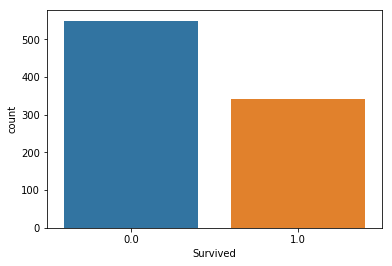

In [6]:
sns.countplot(data['Survived'])

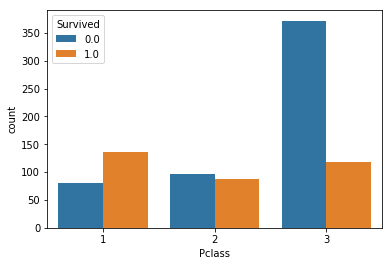

In [7]:
sns.countplot(data['Pclass'], hue=data['Survived'])

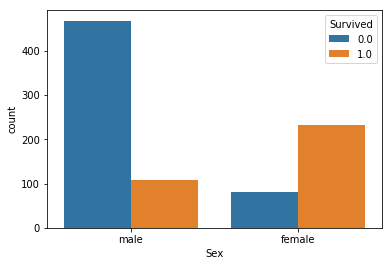

In [8]:
sns.countplot(data['Sex'], hue=data['Survived'])

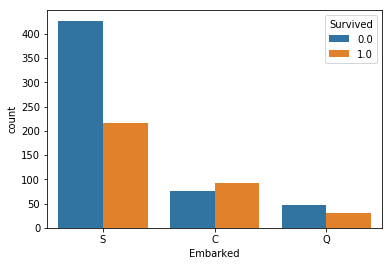

In [9]:
sns.countplot(data['Embarked'], hue=data['Survived'])

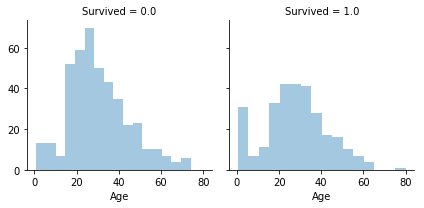

In [10]:
g = sns.FacetGrid(data, col='Survived')
g.map(sns.distplot, 'Age', kde=False)

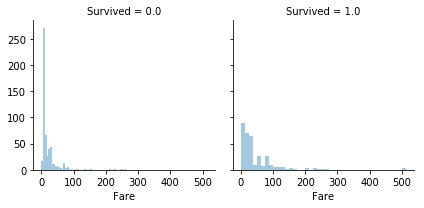

In [11]:
g = sns.FacetGrid(data, col='Survived')
g.map(sns.distplot, 'Fare', kde=False)

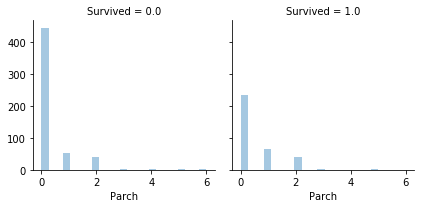

In [12]:
g = sns.FacetGrid(data, col='Survived')
g.map(sns.distplot, 'Parch', kde=False)

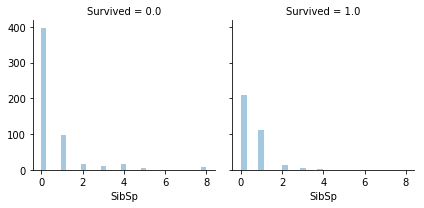

In [13]:
g = sns.FacetGrid(data, col='Survived')
g.map(sns.distplot, 'SibSp', kde=False)

## Feature Engineering

Filling the missing values.

In [14]:
data['Embarked'] = data['Embarked'].fillna('S')
data.loc[data.Fare.isnull(), 'Fare'] = data[(data.Pclass==1)&(data.Embarked=="S")&(data.Sex=="male")].dropna().Fare.mean()
data["Cabin"] = data['Cabin'].apply(lambda x : str(x)[0] if not pd.isnull(x) else 'NoCabin')

Text(0.5, 1.0, 'Age vs Survived in Pclass = 1 and  2')

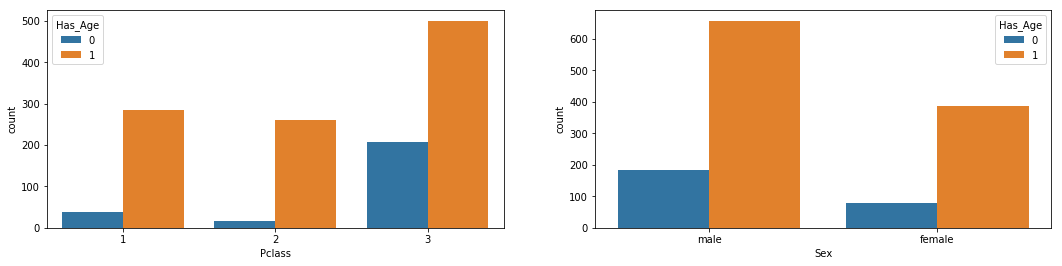

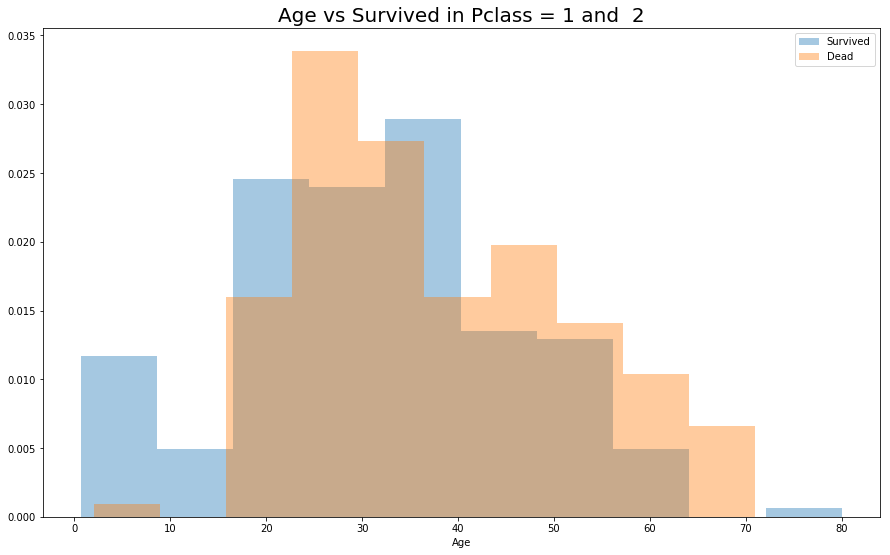

In [39]:
data['Has_Age'] = data['Age'].isnull().map(lambda x : 0 if x == True else 1)
fig, [ax1, ax2] = plt.subplots(1, 2)
fig.set_figwidth(18)
ax1 = sns.countplot(data['Pclass'],hue=data['Has_Age'],ax=ax1)
ax2 = sns.countplot(data['Sex'],hue=data['Has_Age'],ax=ax2)
pd.crosstab(data['Has_Age'],data['Sex'],margins=True).round(3)
# Masks
Mask_Has_Age_P12_Survived = ( (data.Has_Age == 1) & (data.Pclass != 3 ) & (data.Survived == 1) )
Mask_Has_Age_P12_Dead = ( (data.Has_Age == 1) & (data.Pclass != 3 ) & (data.Survived == 0) )
# Plot
fig, ax = plt.subplots( figsize = (15,9) )
ax = sns.distplot(data.loc[Mask_Has_Age_P12_Survived, 'Age'],kde=False,bins=10,norm_hist=True,label='Survived') 
ax = sns.distplot(data.loc[Mask_Has_Age_P12_Dead, 'Age'],kde=False,bins=10,norm_hist=True,label='Dead')
ax.legend()
ax.set_title('Age vs Survived in Pclass = 1 and  2',fontsize = 20)

We extract a new feature "Title" from "Name".

In [15]:
# extracted title using name
data['Title'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
data['Title'] = data['Title'].replace(['Capt', 'Col', 'Countess', 'Don',
                                               'Dr', 'Dona', 'Jonkheer', 
                                                'Major','Rev','Sir'],'Rare') 
data['Title'] = data['Title'].replace(['Mlle', 'Ms','Mme'],'Miss')
data['Title'] = data['Title'].replace(['Lady'],'Mrs')
data['Title'] = data['Title'].map({"Mr":0, "Rare" : 1, "Master" : 2,"Miss" : 3, "Mrs" : 4 })
Ti = data.groupby('Title')['Age'].median()
Ti

Title
0    29.0
1    47.0
2     4.0
3    22.0
4    36.0
Name: Age, dtype: float64

If age is less then 16, high posibility to survive. If age is greater than 60, high posibility not to survive. Extract a new feature "Ti_Minor" and "Ti_Older".

In [16]:
Ti_pred = data.groupby('Title')['Age'].median().values
data['Ti_Age'] = data['Age']
# Filling the missing age
for i in range(0,5):
 # 0 1 2 3 4 5
    data.loc[(data.Age.isnull()) & (data.Title == i),'Ti_Age'] = Ti_pred[i]
data['Ti_Age'] = data['Ti_Age'].astype('int')
data['Ti_Minor'] = ((data['Ti_Age']) < 16.0) * 1
data['Ti_Older'] = ((data['Ti_Age']) > 60.0) * 1

To prevent overfitting, make 5 bins on "Fare".

In [17]:
# Making Bins
from sklearn.preprocessing import LabelEncoder
data['FareBin_5'] = pd.qcut(data['Fare'], 5)

label = LabelEncoder()
data['FareBin_Code_5'] = label.fit_transform(data['FareBin_5'])

Convert "Sex_code" from categorical feature . to numerical feature.

In [18]:
# Convert Sex
data['Sex_Code'] = data['Sex'].map({'female' : 1, 'male' : 0}).astype('int')

Instead of using "SibSp" and "Parch", we compute the whole family size.

In [19]:
data['Family_size'] = data['SibSp'] + data['Parch'] + 1

If people have same kind of tickets, their survival rate might be related.

In [20]:
duplicate_ticket = []
for tk in data.Ticket.unique():
    tem = data.loc[data.Ticket == tk, 'Fare']
    #print(tem.count())
    if tem.count() > 1:
        #print(df_data.loc[df_data.Ticket == tk,['Name','Ticket','Fare']])
        duplicate_ticket.append(data.loc[data.Ticket == tk,['Name','Ticket','Fare','Cabin','Family_size','Survived']])
duplicate_ticket = pd.concat(duplicate_ticket)

In [21]:
# the same ticket family or friends
data['Connected_Survival'] = 0.5 # default 
for _, grp in data.groupby('Ticket'):
    if (len(grp) > 1):
        for ind, row in grp.iterrows():
            smax = grp.drop(ind)['Survived'].max()
            smin = grp.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                data.loc[data['PassengerId'] == passID, 'Connected_Survival'] = 1
            elif (smin==0.0):
                data.loc[data['PassengerId'] == passID, 'Connected_Survival'] = 0
#print
print('people keep the same ticket: %.0f '%len(duplicate_ticket))
print("people have connected information : %.0f" 
      %(data[data['Connected_Survival']!=0.5].shape[0]))
data.groupby('Connected_Survival')[['Survived']].mean().round(3)

people keep the same ticket: 596 
people have connected information : 496


,Survived
Connected_Survival,
0.0,0.225
0.5,0.298
1.0,0.728


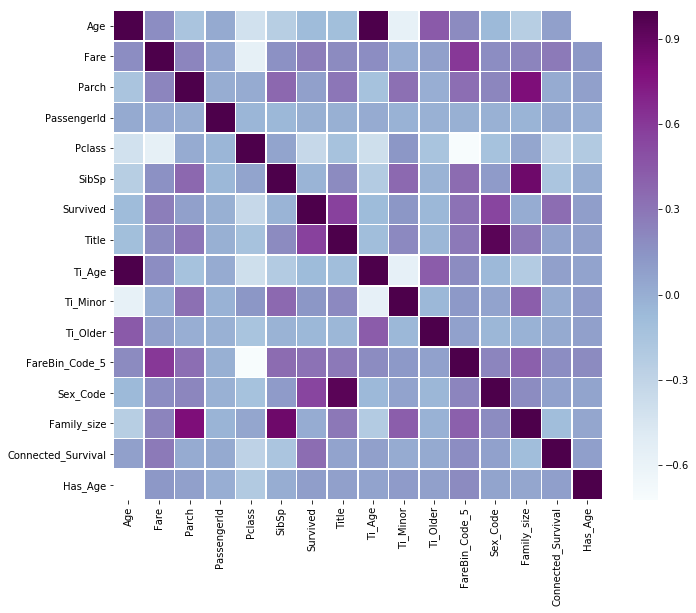

In [40]:
corr_all = data.corr()

# Generate a mask for the upper triangle
#mask = np.zeros_like(corr_all, dtype = np.bool)
#mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

## Select and train models + Fine-Tune hyperparameters

Seperate train and test sets. I want to use an ensembling method (stacking). Therefore, I also seperate the feature and target in the train set.

In [22]:
train = data[:len(train)]
test = data[len(train):]
# Training set and labels
X = train.drop(labels=['Survived','PassengerId'],axis=1)
Y = train['Survived']

Select the features that I feel useful for training and prediction.

In [23]:
new = ['Sex_Code','Pclass','FareBin_Code_5','Family_size', 'Ti_Minor', 'Ti_Older', 'Connected_Survival']

Build the train and validation sets for the first layer of the stacking model.

In [24]:
training, valid, ytraining, yvalid=train_test_split(X,Y,test_size=0.5)

In stacking, I use two layers. The first layer contains two base models (random forest and KNN). And the second layer uses random forest as the meta model. And I use GridSearch to fine-tune the hyperparameters of each model.

In [25]:
param_grid=[{'n_estimators':[100,250,500]},{'min_samples_split':[10,20,100]}]
rfc=RandomForestClassifier()
rfc_search=GridSearchCV(rfc,param_grid,cv=5,scoring='neg_mean_squared_error')
rfc_search.fit(training[new],ytraining)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [100, 250, 500]}, {'min_samples_split': [10, 20, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [26]:
rfc_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Fit data to random forest in the first layer.

In [27]:
model1=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
model1.fit(training[new],ytraining)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [28]:
param_grid=[{'n_neighbors':[3,5,10]},{'leaf_size':[20,30,100]}]
knn=KNeighborsClassifier()
knn_search=GridSearchCV(knn,param_grid,cv=5,scoring='neg_mean_squared_error')
knn_search.fit(training[new],ytraining)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_neighbors': [3, 5, 10]}, {'leaf_size': [20, 30, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [29]:
knn_search.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=100, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

Fit data to KNN in the first layer.

In [30]:
model2=KNeighborsClassifier(algorithm='auto', leaf_size=20, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')
model2.fit(training[new],ytraining)

KNeighborsClassifier(algorithm='auto', leaf_size=20, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [31]:
pred1=model1.predict(valid[new])
pred2=model2.predict(valid[new])

In [32]:
test_pred1=model1.predict(test[new])
test_pred2=model2.predict(test[new])

In [33]:
stacked_pred=np.column_stack((pred1,pred2))
stacked_test_pred=np.column_stack((test_pred1,test_pred2))

In [34]:
param_grid=[{'n_estimators':[100,250,500]},{'min_samples_split':[10,20,100]}]
meta_rfc=RandomForestClassifier()
meta_rfc_search=GridSearchCV(meta_rfc,param_grid,cv=5,scoring='neg_mean_squared_error')
meta_rfc_search.fit(stacked_pred,yvalid)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [100, 250, 500]}, {'min_samples_split': [10, 20, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [35]:
meta_rfc_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Output the final prediction

Fit data to random forest (meta model) in the second layer and output the result.

In [36]:
meta_model=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
meta_model.fit(stacked_pred,yvalid)
new_pred =meta_model.predict(stacked_test_pred)

Make the result a visible data frame.

In [37]:
submit = pd.DataFrame({"PassengerId": test['PassengerId'],
                      "Survived":new_pred.astype(int)})
submit.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
